# 气候观察者模型


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
import pandas as pd
import numpy as np

## 一次运行

/Users/songshgeo/Documents/VSCode/past1000/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/songshgeo/Documents/VSCode/past1000/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[16:47:09][WARNING][datacollector] No final reporters have been definedreturning empty DataFrame.


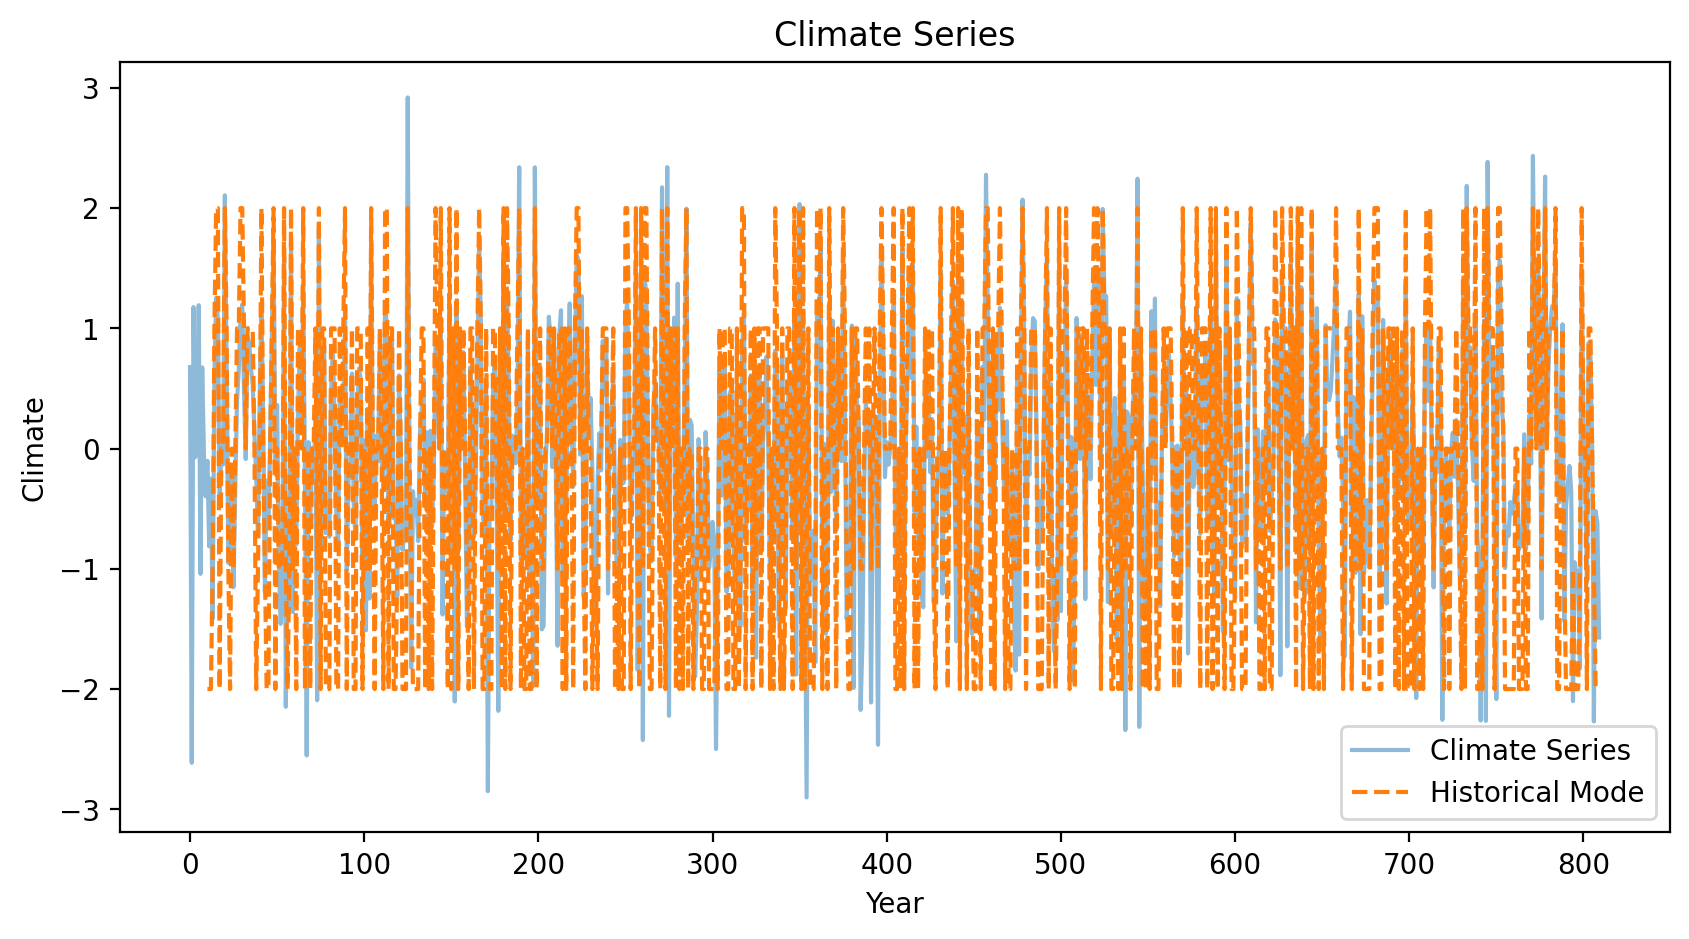

In [8]:
from past1000.abm import Model
import matplotlib.pyplot as plt

# 运行模型
parameters = {
    "years": 300,
    "max_age": 60,
    "loss_rate": 0.4,
    "new_agents": 10,
    "min_age": 10,
    "rejudge": False,
}
model = Model(parameters={"model": parameters})
model.run_model()

# 绘制气候序列和历史平均
fig, ax = plt.subplots(figsize=(10, 5))
model.climate_series.plot(ax=ax, label="Climate Series", alpha=0.5)
model.mode.plot(ax=ax, label="Historical Mode", linestyle="--")
ax.set_title("Climate Series")
ax.set_xlabel("Year")
ax.set_ylabel("Climate")
ax.legend()
plt.show();

In [12]:
model.estimation

,value,expect,classified
510,0.607874,1.0,1
511,-0.088258,0.0,0
512,0.939895,1.0,1
513,0.707692,1.0,1
514,-1.251336,-1.0,-2
...,...,...,...
804,0.787018,1.0,1
805,0.042245,0.0,0
806,-2.269161,-1.0,-2
807,-0.519034,-2.0,-1


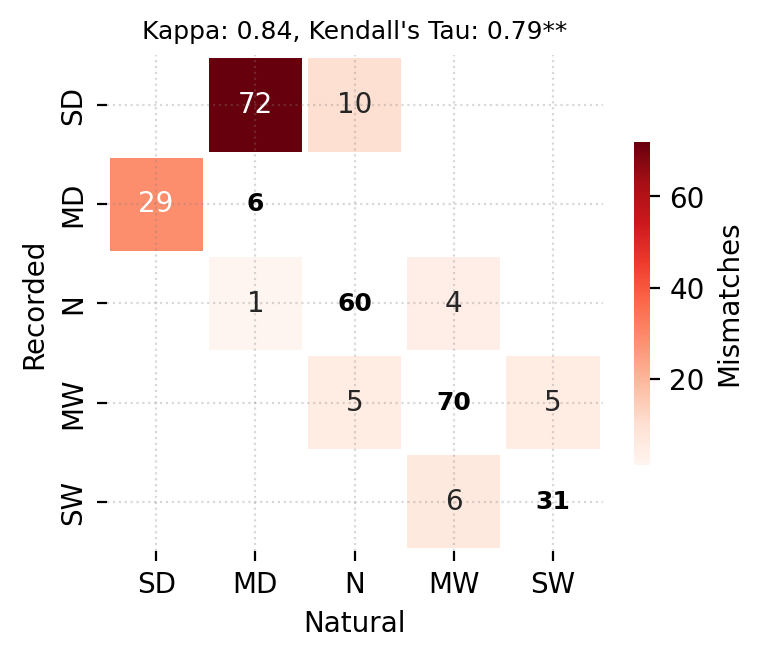

In [14]:
from past1000.calibration import (
    analyze_mismatch,
    notna_confusion_matrix,
    mismatch_stats,
    dropna_series,
)
from past1000.utils.plot import plot_confusion_matrix
from past1000.constants import TICK_LABELS
from past1000.abm import Model


cm_df = notna_confusion_matrix(
    y_true=model.estimation["classified"],
    y_pred=model.estimation["expect"],
    labels=TICK_LABELS,
    dropna=True,
)
title = mismatch_stats(
    y_true=model.estimation["classified"],
    y_pred=model.estimation["expect"],
    as_str=True,
)
plot_confusion_matrix(cm_df=cm_df, title=title);

/Users/songshgeo/Documents/VSCode/past1000/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/songshgeo/Documents/VSCode/past1000/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


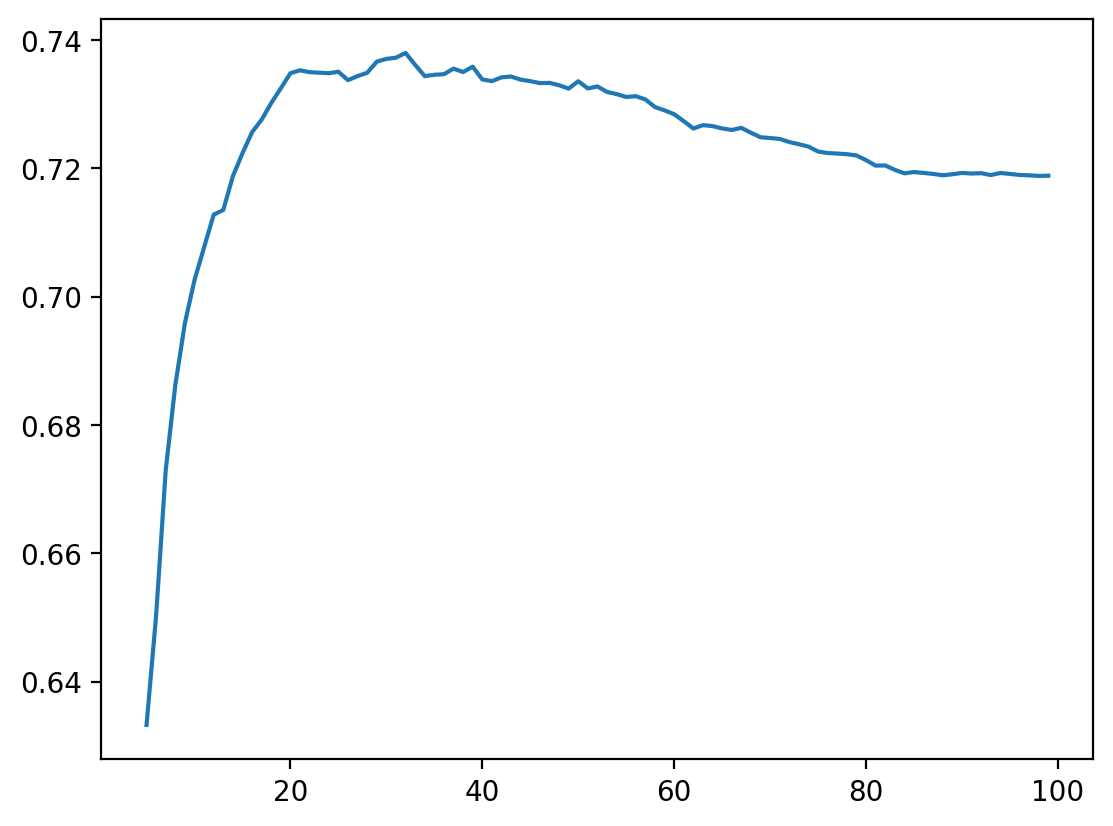

In [17]:
from past1000.compare import compare_corr_2d
from past1000.filters import calc_std_deviation

windows = np.arange(2, 100)
min_periods = np.repeat(2, 98)

rs, ps, ns = compare_corr_2d(
    model.historical_mean,
    model.climate_series,
    windows=windows,
    min_periods=min_periods,
    filter_func=calc_std_deviation,
    corr_method="kendall",
    filter_side="right",
)
plt.plot(windows, rs)

## 读取模型结果

In [2]:
import yaml
from hydra import compose, initialize

with initialize(config_path="../config", version_base=None):
    cfg = compose(config_name="config")

path = Path(cfg.ds.abm)

datasets = []

for subdir in path.iterdir():
    if subdir.is_dir():
        corr_file = subdir / "correlations.csv"
        hydra_config = subdir / ".hydra" / "overrides.yaml"
        if corr_file.exists() and hydra_config.exists():
            # 读取 correlations.csv
            df = pd.read_csv(corr_file, index_col=0)
            long = df.melt(ignore_index=False).reset_index()
            long["run"] = subdir.name

            # 读取 hydra 配置
            with open(hydra_config, "r") as f:
                overrides = yaml.safe_load(f)
            # 解析每个参数
            param_dict = {}
            for item in overrides:
                if "=" in item:
                    key, value = item.split("=", 1)
                    # 只保留 how. 开头的参数（可选）
                    if key.startswith("how."):
                        key = key.replace("how.", "")
                    param_dict[key] = value
            # 将参数字典展开为多列
            for k, v in param_dict.items():
                long[k] = v

            datasets.append(long)

# 合并所有数据
df_all = pd.concat(datasets, ignore_index=True)
# 1. 找每个 (rejudge, max_age, run) 下最大 correlation 的 Year
# 假设 df_all 已经有 'max_age', 'rejudge', 'variable', 'index', 'value'
df_all["index"] = df_all["index"].astype(int)
df_all["max_age"] = df_all["max_age"].astype(int) - df_all["min_age"].astype(int)
df_all.head()

,index,variable,value,run,how,max_age,rejudge,min_age,loss_rate,new_agents
0,2,model_0,NaN,135,abm,15,False,20,0.4,5
1,3,model_0,NaN,135,abm,15,False,20,0.4,5
2,4,model_0,NaN,135,abm,15,False,20,0.4,5
3,5,model_0,NaN,135,abm,15,False,20,0.4,5
4,6,model_0,NaN,135,abm,15,False,20,0.4,5


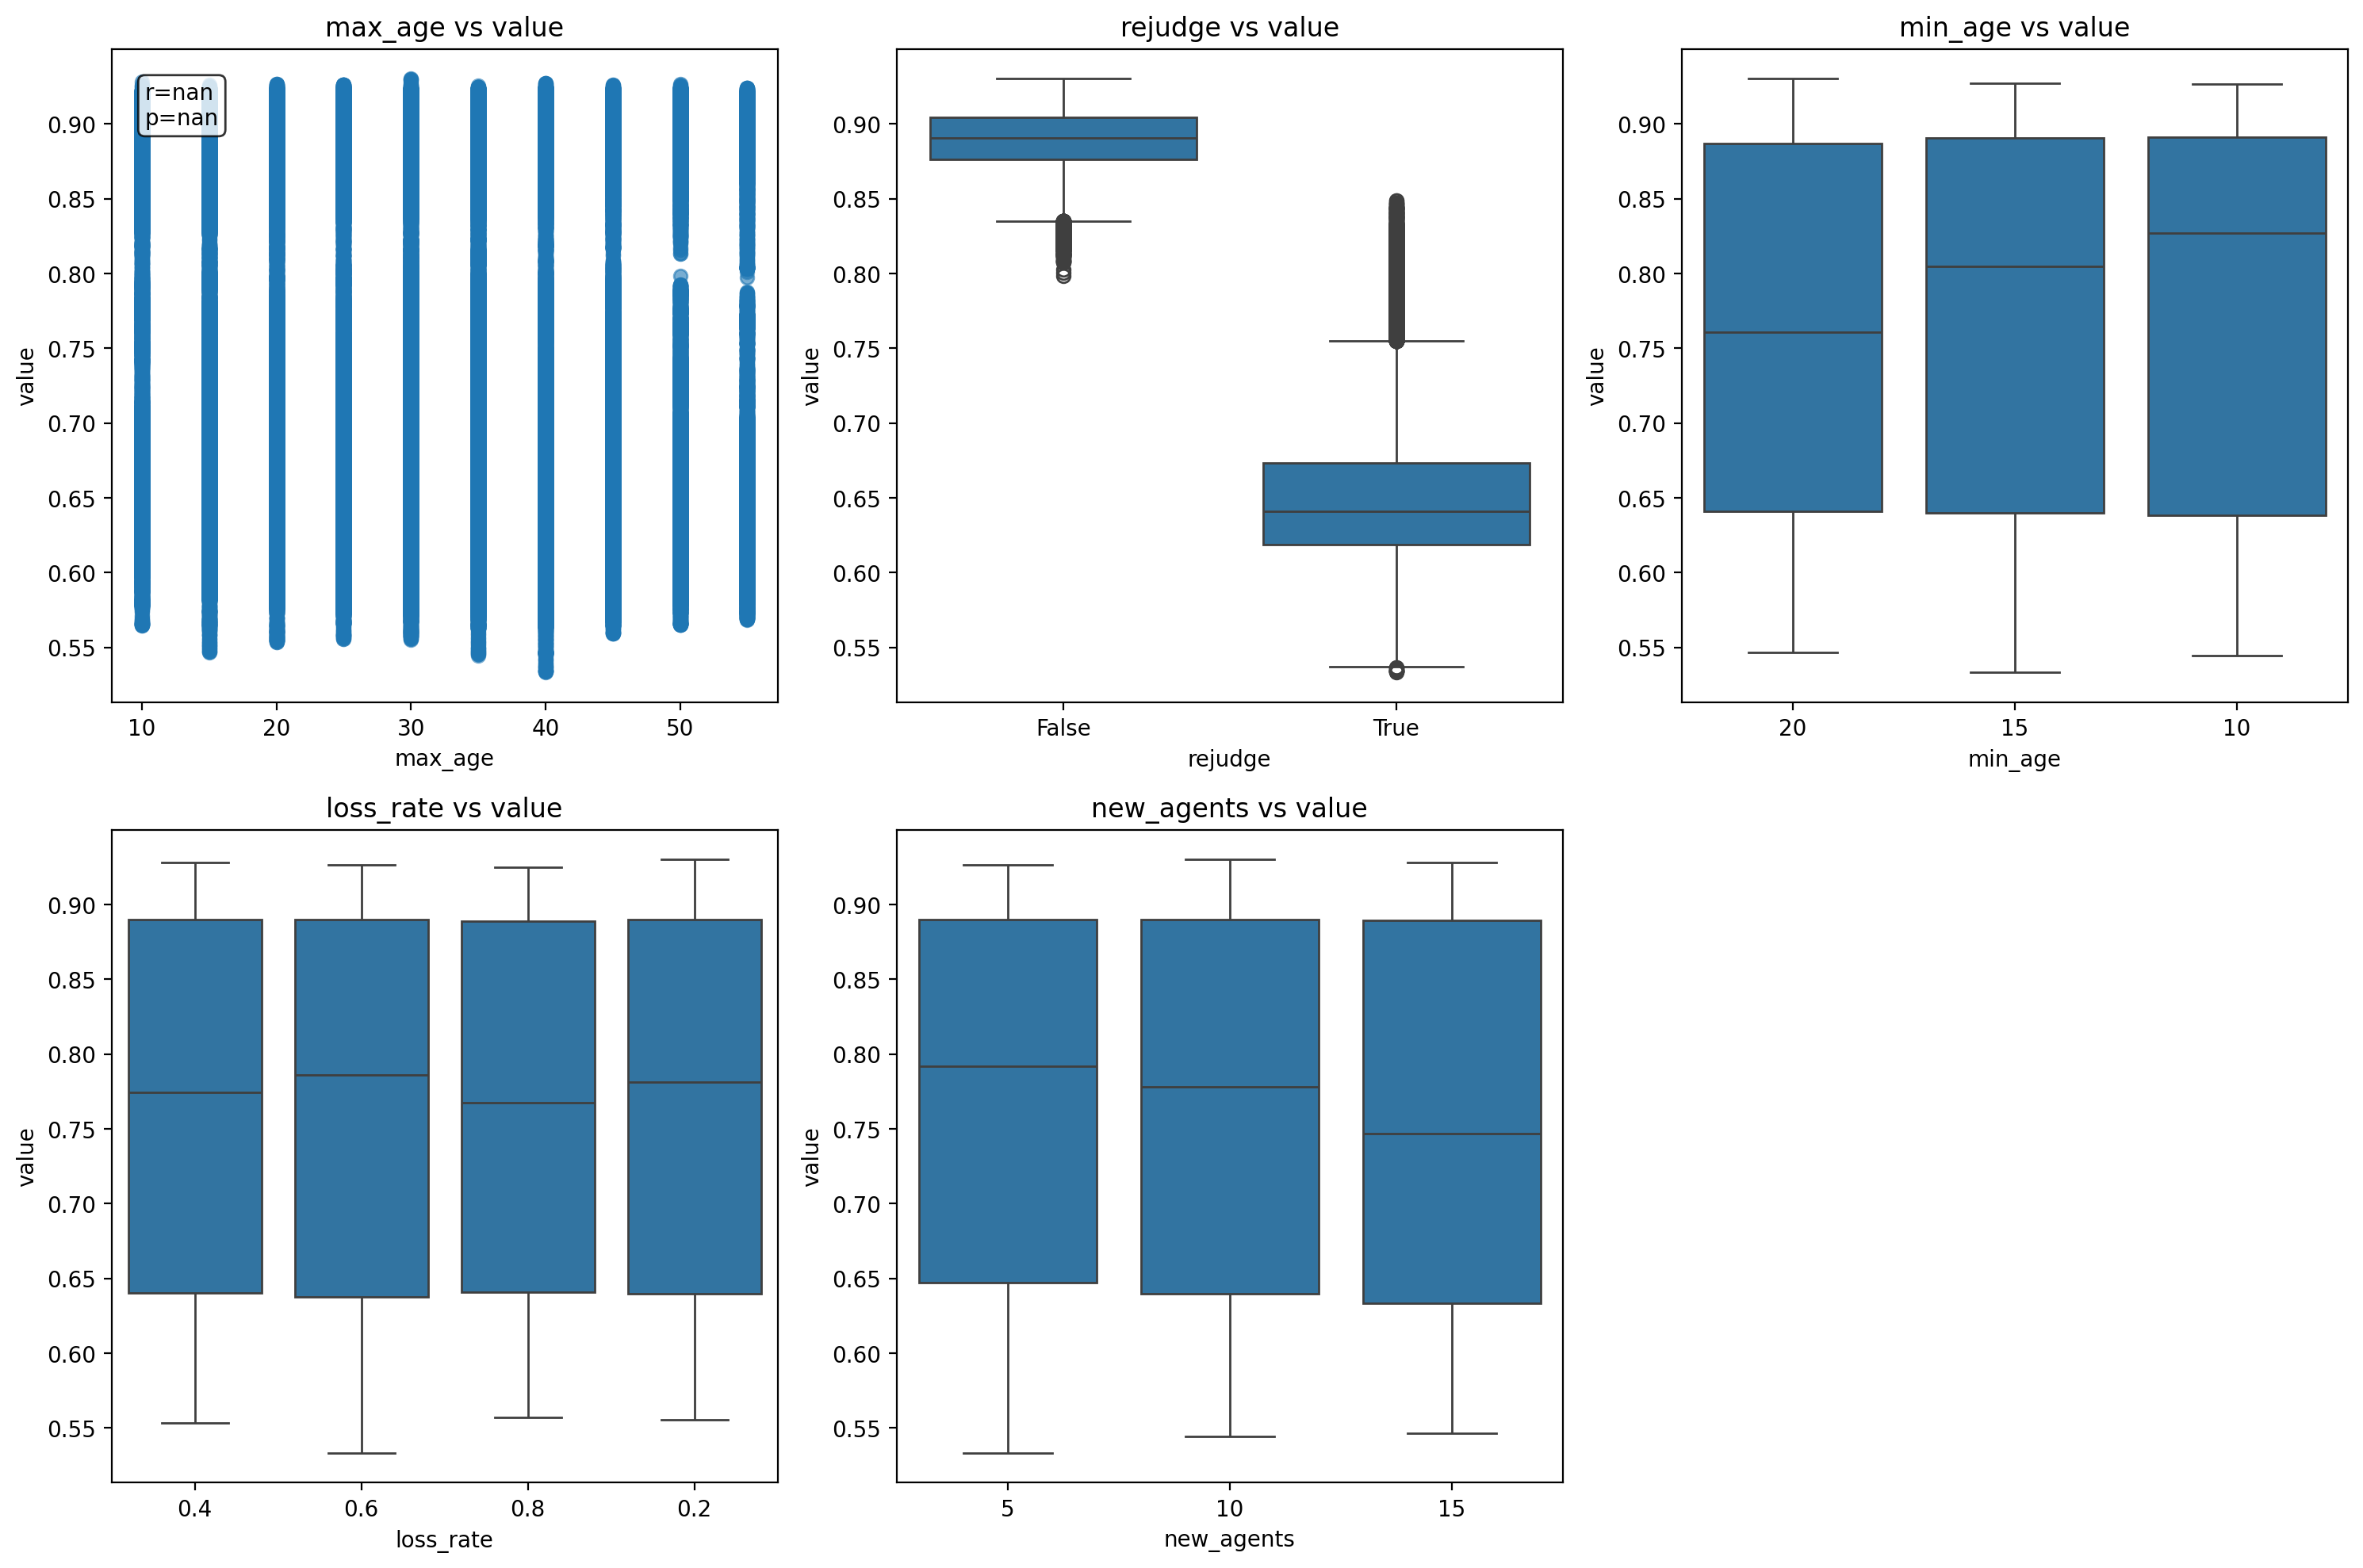

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import numpy as np


def single_factor_sensitivity(df, target_col="value"):
    """
    单因子敏感性分析：一次只变化一个参数

    Args:
        df: 数据框
        target_col: 目标变量列名

    Returns:
        sensitivity_results: 敏感性分析结果
    """
    params = ["max_age", "rejudge", "min_age", "loss_rate", "new_agents"]
    results = {}

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, param in enumerate(params):
        ax = axes[i]

        if df[param].dtype == "object" or df[param].nunique() < 10:
            # 分类变量：箱线图
            sns.boxplot(data=df, x=param, y=target_col, ax=ax)
            ax.set_title(f"{param} vs {target_col}")

            # 方差分析
            groups = [group[target_col].values for name, group in df.groupby(param)]
            f_stat, p_value = stats.f_oneway(*groups)
            results[param] = {
                "type": "categorical",
                "f_statistic": f_stat,
                "p_value": p_value,
                "effect_size": "eta_squared",  # 需要计算
            }

        else:
            # 连续变量：散点图和相关性
            ax.scatter(df[param], df[target_col], alpha=0.6)
            ax.set_xlabel(param)
            ax.set_ylabel(target_col)
            ax.set_title(f"{param} vs {target_col}")

            # 添加趋势线
            z = np.polyfit(df[param], df[target_col], 1)
            p = np.poly1d(z)
            ax.plot(df[param], p(df[param]), "r--", alpha=0.8)

            # 相关性分析
            pearson_r, pearson_p = pearsonr(df[param], df[target_col])
            spearman_r, spearman_p = spearmanr(df[param], df[target_col])

            results[param] = {
                "type": "continuous",
                "pearson_r": pearson_r,
                "pearson_p": pearson_p,
                "spearman_r": spearman_r,
                "spearman_p": spearman_p,
            }

            # 在图上显示相关系数
            ax.text(
                0.05,
                0.95,
                f"r={pearson_r:.3f}\np={pearson_p:.3f}",
                transform=ax.transAxes,
                verticalalignment="top",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
            )

    # 移除多余的子图
    if len(params) < len(axes):
        for j in range(len(params), len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    return results


# 运行单因子分析
single_results = single_factor_sensitivity(df_all)

In [10]:
def multi_factor_anova(df, target_col="value"):
    """
    多因子方差分析，评估参数的主效应和交互效应

    Args:
        df: 数据框
        target_col: 目标变量

    Returns:
        anova_results: ANOVA分析结果
    """
    from statsmodels.stats.anova import anova_lm
    from statsmodels.formula.api import ols

    # 准备数据：确保分类变量是字符串类型
    df_anova = df.copy()
    categorical_params = ["rejudge"]
    for param in categorical_params:
        df_anova[param] = df_anova[param].astype(str)

    # 构建模型公式
    continuous_params = ["max_age", "min_age", "loss_rate", "new_agents"]
    all_params = categorical_params + continuous_params

    # 主效应模型
    main_formula = f"{target_col} ~ " + " + ".join(all_params)

    # 包含二阶交互效应的模型
    interaction_formula = f"{target_col} ~ (" + " + ".join(all_params) + ")**2"

    print("=== 主效应ANOVA ===")
    main_model = ols(main_formula, data=df_anova).fit()
    main_anova = anova_lm(main_model, typ=2)
    print(main_anova)

    print("\n=== 包含交互效应的ANOVA ===")
    interaction_model = ols(interaction_formula, data=df_anova).fit()
    interaction_anova = anova_lm(interaction_model, typ=2)
    print(interaction_anova)

    # 计算效应大小 (Eta squared)
    def calculate_eta_squared(anova_table):
        anova_table["eta_sq"] = anova_table["sum_sq"] / anova_table["sum_sq"].sum()
        return anova_table

    main_anova_with_eta = calculate_eta_squared(main_anova)
    interaction_anova_with_eta = calculate_eta_squared(interaction_anova)

    return {
        "main_effects": main_anova_with_eta,
        "with_interactions": interaction_anova_with_eta,
        "main_model": main_model,
        "interaction_model": interaction_model,
    }


# 运行多因子ANOVA
anova_results = multi_factor_anova(df_all)

=== 主效应ANOVA ===
                 sum_sq        df             F         PR(>F)
rejudge     7293.509095       1.0  5.749253e+06   0.000000e+00
min_age        0.729600       2.0  2.875609e+02  1.524661e-125
loss_rate      0.033926       3.0  8.914312e+00   6.667188e-06
new_agents     6.731726       2.0  2.653208e+03   0.000000e+00
max_age        0.162623       1.0  1.281911e+02   1.027626e-29
Residual     657.072004  517950.0           NaN            NaN

=== 包含交互效应的ANOVA ===
                           sum_sq        df             F         PR(>F)
rejudge               7272.531060       1.0  6.146287e+06   0.000000e+00
min_age                  1.221212       2.0  5.160459e+02  1.279766e-224
loss_rate                0.023100       3.0  6.507673e+00   2.131377e-04
new_agents               6.633459       2.0  2.803091e+03   0.000000e+00
rejudge:min_age          0.841844       2.0  3.557369e+02  4.087251e-155
rejudge:loss_rate        0.014441       3.0  4.068314e+00   6.713506e-03
rejudge:n

In [4]:
def find_max_correlation_by_all_params(
    df, target_col="value", time_col="index", exclude_cols=None
):
    """
    根据所有参数列分组，找到每组目标变量达到最大值的时间点

    Args:
        df: 数据框
        target_col: 目标变量列名（默认'value'）
        time_col: 时间列名（默认'index'）
        exclude_cols: 需要排除的列名列表（可选）

    Returns:
        DataFrame: 每组最大值对应的时间点和参数信息
    """
    # 默认排除的列
    default_exclude = {"index", "variable", "value", "run", "how"}

    if exclude_cols is not None:
        exclude_cols = set(exclude_cols)
        exclude_cols.update(default_exclude)
    else:
        exclude_cols = default_exclude

    # 自动识别参数列
    all_cols = set(df.columns)
    param_cols = list(all_cols - exclude_cols)

    print(f"使用的分组参数: {param_cols}")
    print(f"排除的列: {sorted(exclude_cols)}")

    # 定义分组函数
    def get_max_info(group):
        max_idx = group[target_col].idxmax()
        max_row = group.loc[max_idx]
        return pd.Series(
            {
                "max_year": max_row[time_col],
                "max_value": max_row[target_col],
                "group_size": len(group),
            }
        )

    # 执行分组和聚合
    result = (
        df.groupby(param_cols, dropna=False)
        .apply(get_max_info, include_groups=False)
        .reset_index()
    )

    # 重命名列以更清晰
    result = result.rename(
        columns={
            "max_year": f"Year_of_Max_{target_col}",
            "max_value": f"Max_{target_col}",
        }
    )

    return result


# 使用函数
max_points_comprehensive = find_max_correlation_by_all_params(df_all)
print(f"\n总共找到 {len(max_points_comprehensive)} 个参数组合")
max_points_comprehensive.head(10)

使用的分组参数: ['max_age', 'new_agents', 'rejudge', 'min_age', 'loss_rate']
排除的列: ['how', 'index', 'run', 'value', 'variable']

总共找到 563 个参数组合


,max_age,new_agents,rejudge,min_age,loss_rate,Year_of_Max_value,Max_value,group_size
0,10,10,False,20,0.2,17.0,0.918254,980.0
1,10,10,False,20,0.4,19.0,0.923118,980.0
2,10,10,False,20,0.6,17.0,0.920823,980.0
3,10,10,False,20,0.8,17.0,0.918066,980.0
4,10,10,True,20,0.2,12.0,0.701372,980.0
5,10,10,True,20,0.4,23.0,0.795460,980.0
6,10,10,True,20,0.6,20.0,0.812054,980.0
7,10,10,True,20,0.8,20.0,0.769265,980.0
8,10,15,False,20,0.2,14.0,0.921857,980.0
9,10,15,False,20,0.4,18.0,0.928111,980.0


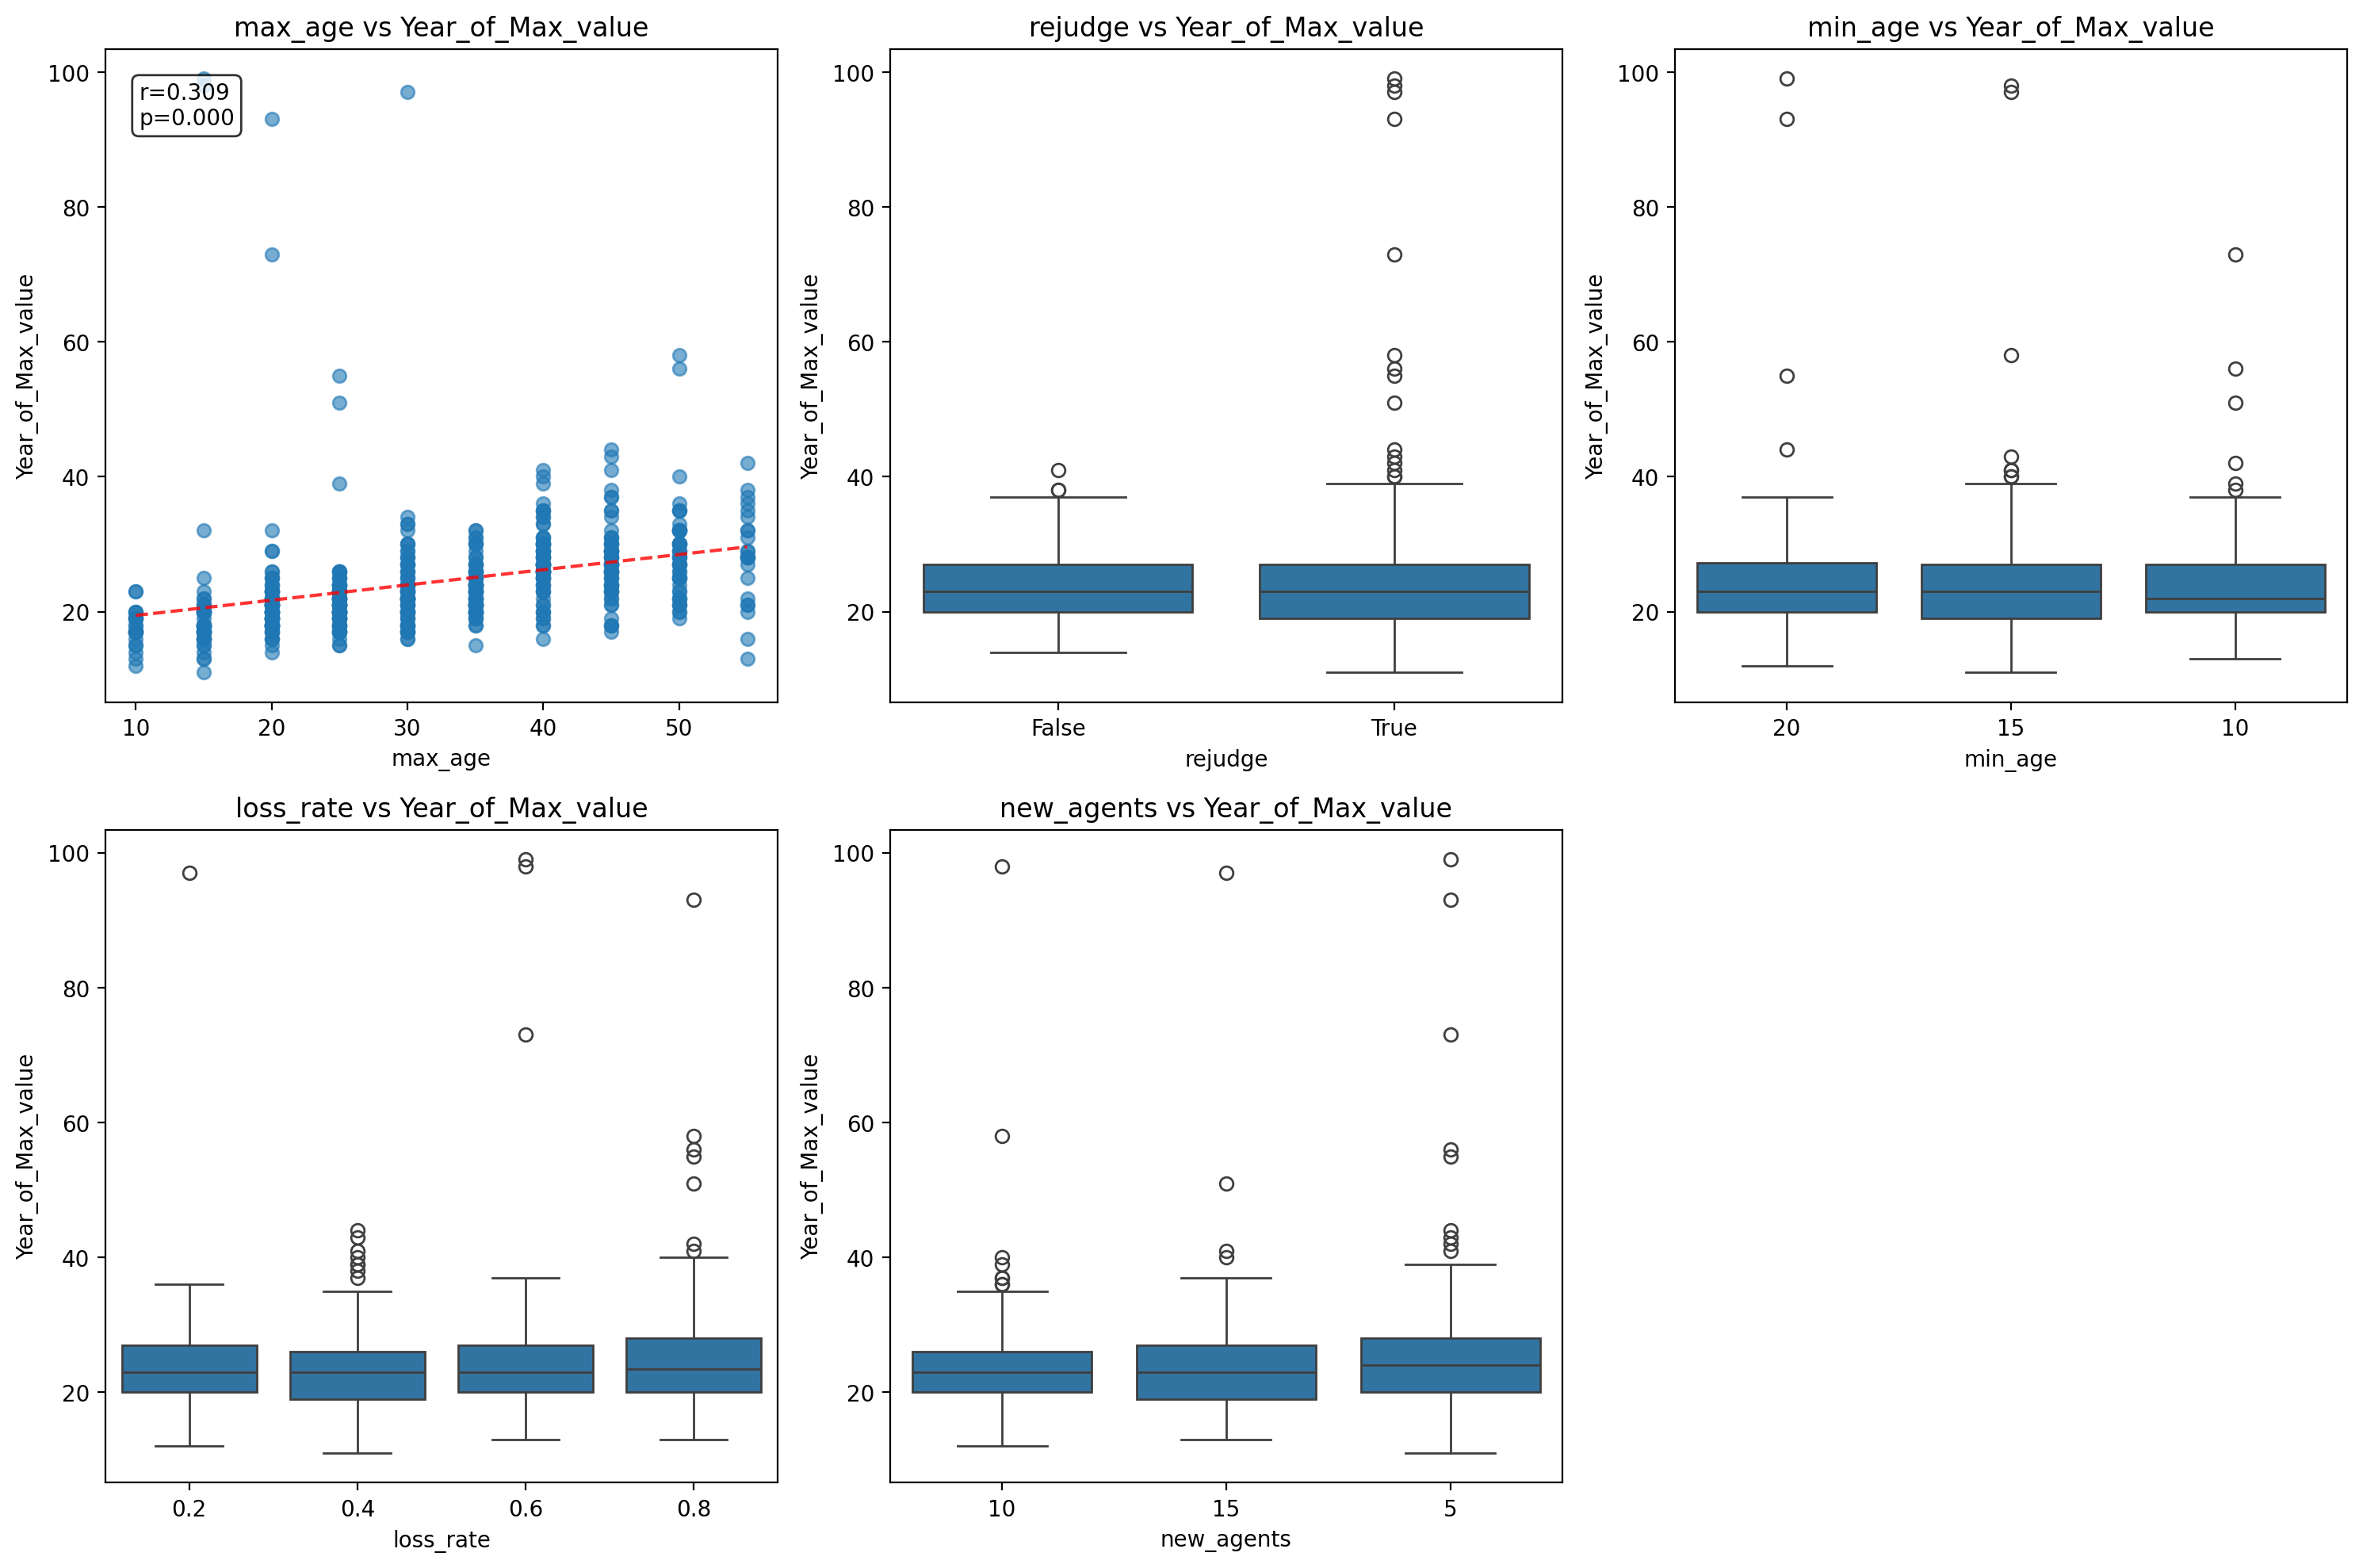

{'max_age': {'type': 'continuous',
  'pearson_r': 0.3086282375451215,
  'pearson_p': 6.868632146077335e-14,
  'spearman_r': 0.5920075775601843,
  'spearman_p': 1.5383037552385688e-54},
 'rejudge': {'type': 'categorical',
  'f_statistic': 3.2959773558529672,
  'p_value': 0.06998352667685521,
  'effect_size': 'eta_squared'},
 'min_age': {'type': 'categorical',
  'f_statistic': 0.1587106530182109,
  'p_value': 0.8532815722603985,
  'effect_size': 'eta_squared'},
 'loss_rate': {'type': 'categorical',
  'f_statistic': 1.3769950164339826,
  'p_value': 0.2488489156427578,
  'effect_size': 'eta_squared'},
 'new_agents': {'type': 'categorical',
  'f_statistic': 1.9220662531371806,
  'p_value': 0.147268289723319,
  'effect_size': 'eta_squared'}}

In [7]:
single_factor_sensitivity(max_points_comprehensive, target_col="Year_of_Max_value")

In [11]:
multi_factor_anova(max_points_comprehensive, target_col="Year_of_Max_value")

=== 主效应ANOVA ===
                  sum_sq     df          F        PR(>F)
rejudge       176.625384    1.0   2.541152  1.114852e-01
min_age       911.273313    2.0   6.555354  1.535572e-03
loss_rate     333.591823    3.0   1.599822  1.883885e-01
new_agents    296.945413    2.0   2.136112  1.190867e-01
max_age      5073.243342    1.0  72.989967  1.270323e-16
Residual    38436.838567  553.0        NaN           NaN

=== 包含交互效应的ANOVA ===
                            sum_sq     df          F        PR(>F)
rejudge                 170.154581    1.0   2.473413  1.163922e-01
min_age                 977.921566    2.0   7.107665  9.004577e-04
loss_rate               339.432218    3.0   1.644693  1.780826e-01
new_agents              294.886017    2.0   2.143271  1.183015e-01
rejudge:min_age          27.111602    2.0   0.197051  8.212100e-01
rejudge:loss_rate        72.941662    3.0   0.353433  7.866805e-01
rejudge:new_agents       59.043957    2.0   0.429139  6.512987e-01
min_age:loss_rate       22

{'main_effects':                   sum_sq     df          F        PR(>F)    eta_sq
 rejudge       176.625384    1.0   2.541152  1.114852e-01  0.003905
 min_age       911.273313    2.0   6.555354  1.535572e-03  0.020148
 loss_rate     333.591823    3.0   1.599822  1.883885e-01  0.007376
 new_agents    296.945413    2.0   2.136112  1.190867e-01  0.006565
 max_age      5073.243342    1.0  72.989967  1.270323e-16  0.112169
 Residual    38436.838567  553.0        NaN           NaN  0.849836,
 'with_interactions':                             sum_sq     df          F        PR(>F)    eta_sq
 rejudge                 170.154581    1.0   2.473413  1.163922e-01  0.003750
 min_age                 977.921566    2.0   7.107665  9.004577e-04  0.021554
 loss_rate               339.432218    3.0   1.644693  1.780826e-01  0.007481
 new_agents              294.886017    2.0   2.143271  1.183015e-01  0.006499
 rejudge:min_age          27.111602    2.0   0.197051  8.212100e-01  0.000598
 rejudge:loss_rate

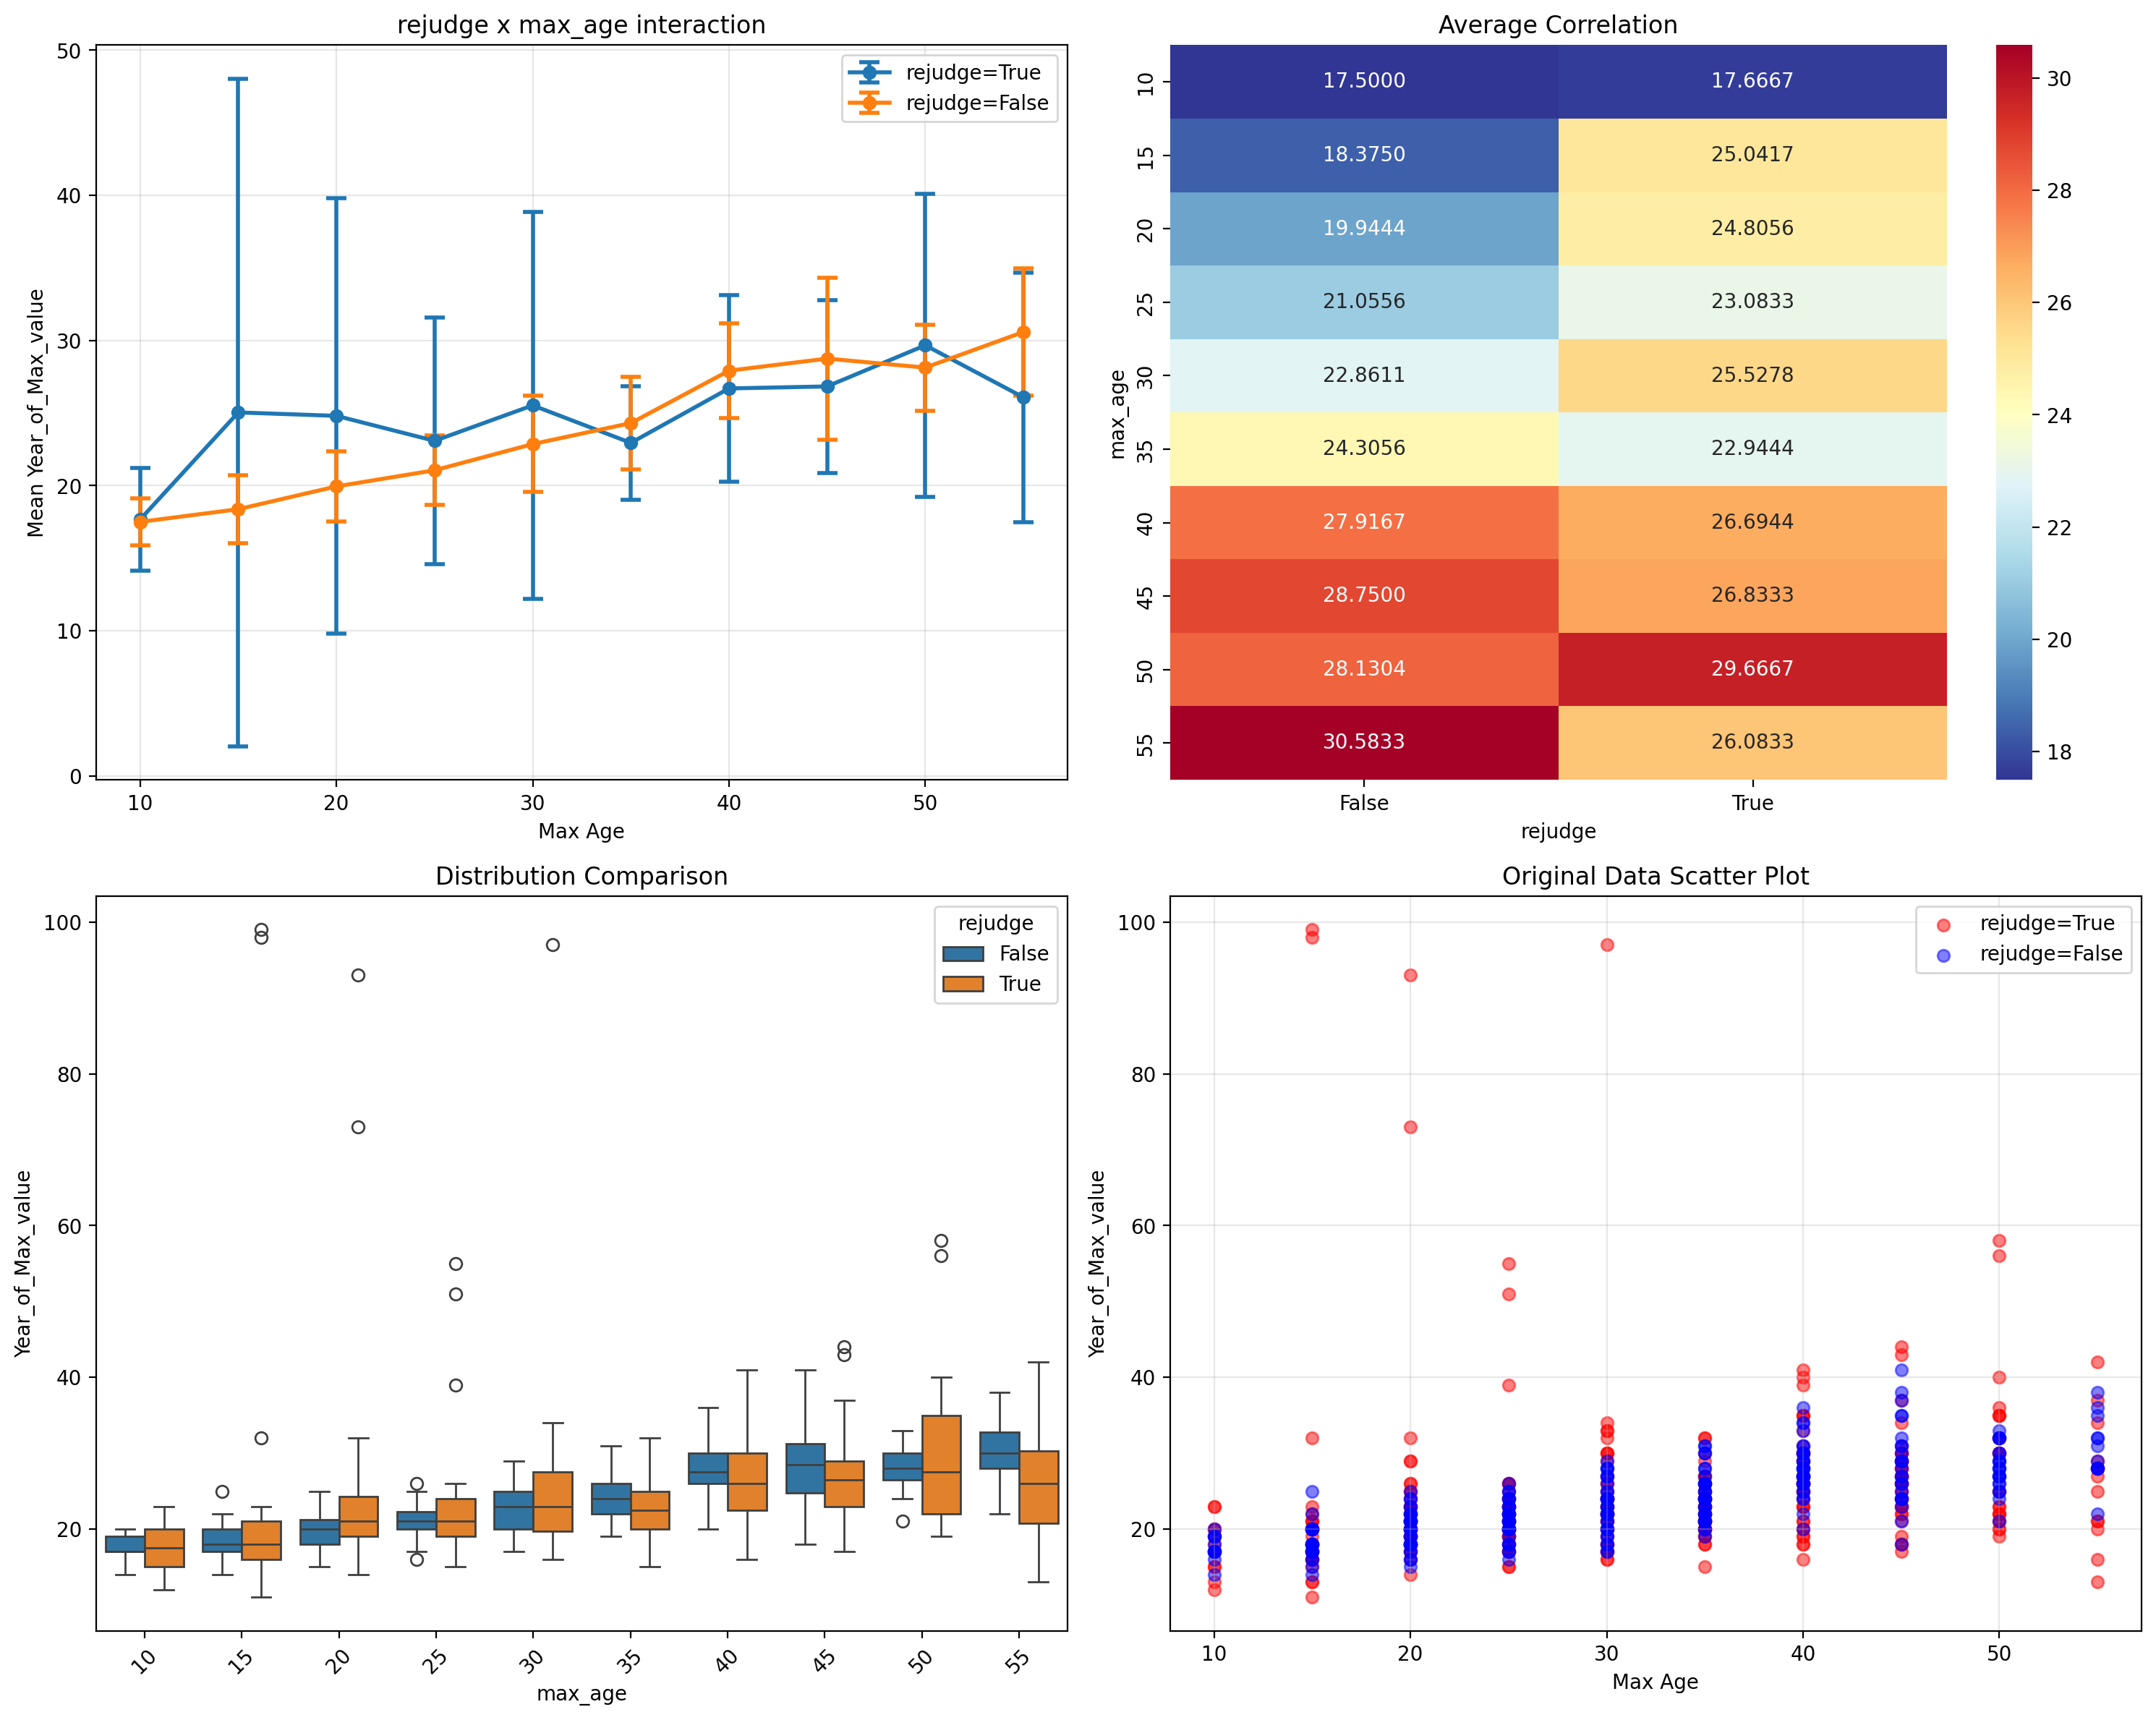

=== 交互效应统计 ===

rejudge = True:
  Number of data points: 288
  Mean of Year_of_Max_value: 25.118056
  Standard deviation of Year_of_Max_value: 11.378503
  max_age range: 10 - 55

rejudge = False:
  Number of data points: 275
  Mean of Year_of_Max_value: 23.760000
  Standard deviation of Year_of_Max_value: 5.055228
  max_age range: 10 - 55


In [14]:
def plot_rejudge_maxage_interaction(df, target_col="value"):
    """
    绘制 rejudge 和 max_age 的交互效应图

    Args:
        df: 数据框
        target_col: 目标变量列名
    """
    # 确保rejudge是字符串类型
    df = df.copy()
    df["rejudge"] = df["rejudge"].astype(str)

    # 创建多种交互图
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. 线图：显示交互效应
    ax1 = axes[0, 0]
    # 计算每个组合的均值
    interaction_data = (
        df.groupby(["max_age", "rejudge"])[target_col]
        .agg(["mean", "std", "count"])
        .reset_index()
    )

    for rejudge_val in ["True", "False"]:
        subset = interaction_data[interaction_data["rejudge"] == rejudge_val]
        ax1.errorbar(
            subset["max_age"],
            subset["mean"],
            yerr=subset["std"],
            marker="o",
            capsize=5,
            capthick=2,
            linewidth=2,
            label=f"rejudge={rejudge_val}",
        )

    ax1.set_xlabel("Max Age")
    ax1.set_ylabel(f"Mean {target_col}")
    ax1.set_title("rejudge x max_age interaction")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. 热图：显示均值分布
    ax2 = axes[0, 1]
    pivot_data = df.pivot_table(
        values=target_col, index="max_age", columns="rejudge", aggfunc="mean"
    )
    sns.heatmap(pivot_data, annot=True, fmt=".4f", cmap="RdYlBu_r", ax=ax2)
    ax2.set_title("Average Correlation")

    # 3. 箱线图：显示分布差异
    ax3 = axes[1, 0]
    sns.boxplot(data=df, x="max_age", y=target_col, hue="rejudge", ax=ax3)
    ax3.set_title("Distribution Comparison")
    ax3.tick_params(axis="x", rotation=45)

    # 4. 散点图：显示原始数据
    ax4 = axes[1, 1]
    for rejudge_val, color in zip(["True", "False"], ["red", "blue"]):
        subset = df[df["rejudge"] == rejudge_val]
        ax4.scatter(
            subset["max_age"],
            subset[target_col],
            alpha=0.5,
            color=color,
            label=f"rejudge={rejudge_val}",
        )

    ax4.set_xlabel("Max Age")
    ax4.set_ylabel(target_col)
    ax4.set_title("Original Data Scatter Plot")
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 输出统计信息
    print("=== 交互效应统计 ===")
    for rejudge_val in ["True", "False"]:
        subset = df[df["rejudge"] == rejudge_val]
        print(f"\nrejudge = {rejudge_val}:")
        print(f"  Number of data points: {len(subset)}")
        print(f"  Mean of {target_col}: {subset[target_col].mean():.6f}")
        print(f"  Standard deviation of {target_col}: {subset[target_col].std():.6f}")
        print(f"  max_age range: {subset['max_age'].min()} - {subset['max_age'].max()}")


# 绘制交互图
plot_rejudge_maxage_interaction(
    max_points_comprehensive, target_col="Year_of_Max_value"
)

### Max Age 作图

/var/folders/s9/w7bh_d6x1h915wcvpbp117tm0000gn/T/ipykernel_71228/1007064530.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.loc[g["value"].idxmax(), "index"])


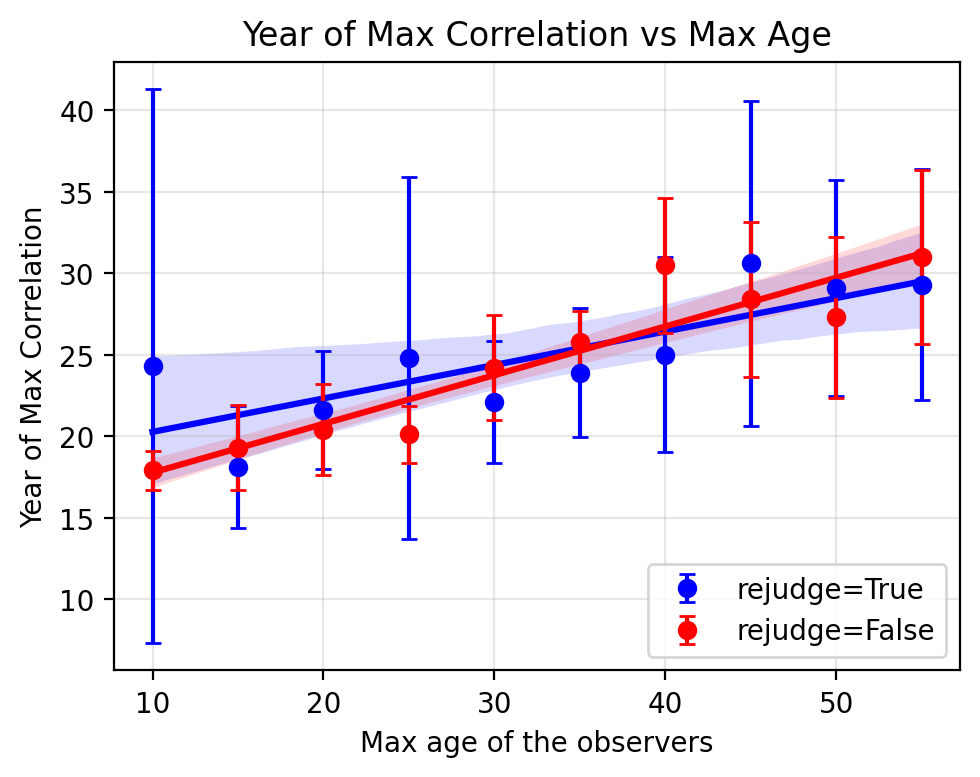

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 以 ['rejudge', 'max_age', 'variable'] 分组，找每个重复的最大相关性出现的 Year
max_years = (
    df_all.groupby(["rejudge", "max_age", "variable"])
    .apply(lambda g: g.loc[g["value"].idxmax(), "index"])
    .reset_index(name="max_corr_year")
)

# 2. 统计每组（rejudge, max_age）下最大 Year 的均值和标准差
summary = (
    max_years.groupby(["rejudge", "max_age"])["max_corr_year"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

# 3. 绘图
plt.figure(figsize=(5, 4))
ax = plt.gca()

# 使用 scatterplot + errorbar 替代 pointplot
for rejudge_val, color in zip(["True", "False"], ["blue", "red"]):
    subset = max_years[max_years["rejudge"] == rejudge_val]

    # 计算每个 max_age 的均值和标准差
    stats = (
        subset.groupby("max_age")["max_corr_year"].agg(["mean", "std"]).reset_index()
    )

    # 绘制错误棒
    ax.errorbar(
        stats["max_age"],
        stats["mean"],
        yerr=stats["std"],
        fmt="o",
        color=color,
        capsize=3,
        label=f"rejudge={rejudge_val}",
    )

    # 添加回归线
    sns.regplot(
        data=subset,
        x="max_age",
        y="max_corr_year",
        scatter=False,
        color=color,
        ax=ax,
    )

plt.ylabel("Year of Max Correlation")
plt.xlabel("Max age of the observers")
plt.title("Year of Max Correlation vs Max Age")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show();